# Flair Classification

In [21]:
import numpy as np
import pandas as pd
from train import _get_cleaned_dataframe
import spacy

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
data = _get_cleaned_dataframe()

In [24]:
data.head()

,permalink,selfpost,selftext,upvotes,timestamp,title,flair,poster,comments
0,/r/india/comments/cyj7gz/kashmir_news_coverage_3/,True,A summary of news coverage on Kashmir in the p...,102,{'$numberInt': '1567391958'},Kashmir News Coverage - 3,Politics,gujjuben,"[{'author': 'HANDSOME_RHYS', 'body': 'I knew S..."
1,/r/india/comments/czue7z/happy_teachers_day/,True,Big thanks to all the teachers who have taught...,72,{'$numberInt': '1567648629'},Happy Teachers Day,[R]eddiquette,R4V3N11,"[{'author': 'NihilistLurker', 'body': 'I appre..."
2,/r/india/comments/czwtnd/i_work_in_medical_sto...,True,"Because she can't afford transport,so I took h...",602,{'$numberInt': '1567663196'},"I work in medical store, today 10 year old gir...",[R]eddiquette,meetu007,"[{'author': '5h1v4u', 'body': 'Good for what y..."
3,/r/india/comments/czvagp/i_transcribed_the_ful...,True,*Transcript of the remarks by Indiaâ€™s former...,485,{'$numberInt': '1567653465'},I transcribed the full text of Dr. Manmohan Si...,Politics,firasd,"[{'author': 'FresnoMac', 'body': 'What's parti..."
4,/r/india/comments/czwmff/shashi_tharoor_i_am_a...,False,,164,{'$numberInt': '1567661758'},Shashi Tharoor: I am a proud Hindu because my ...,Politics,computerbaba7,"[{'author': 'angrybong', 'body': 'Congress is ..."


## Class Imbalance

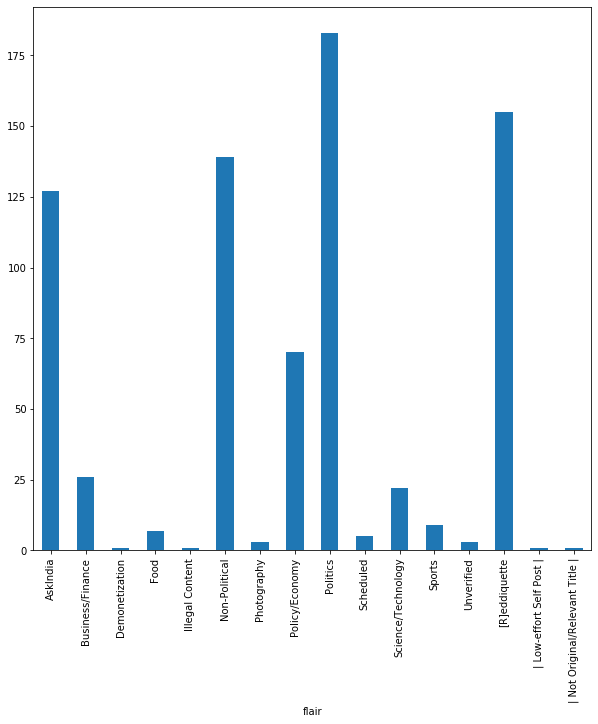

In [25]:
fig = plt.figure(figsize=(10, 10))

data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [26]:
""" 
Drop 4 classes 

- Demonetization
- Illegal Content
- | Low-effort Self Post |
- | Not Original/Relevant Title |

"""
drop_classes = [
        "Demonetization",
        "Illegal Content",
        "| Low-effort Self Post |",
        "| Not Original/Relevant Title |"
    ]

for cls in drop_classes:
    data = data[data["flair"] != cls]

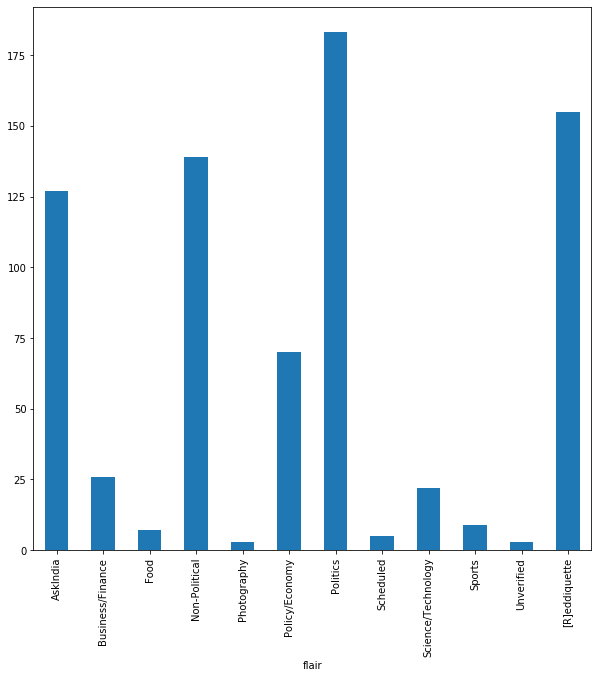

In [27]:
fig = plt.figure(figsize=(10, 10))

data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

# Vectorization

In [28]:
def _concatenate_features(df, features):
    feature_dict = {
        "feature" : []
    }
    for index, row in df.iterrows():
        data = ""
        for feature in features:
            if feature == "comments":
                data += "".join([comment["body"] for comment in row["comments"]])
            else:
                data += row[feature]
        feature_dict["feature"].append(data)
            
    return pd.DataFrame(feature_dict)

In [29]:
# concat_df = _concatenate_features(data, ["title", "permalink", "selftext"])
concat_df = _concatenate_features(data, ["title", "permalink", "comments", "selftext"])

concat_df.shape

(749, 1)

In [30]:
concat_df["feature"][0]

'Kashmir News Coverage - 3/r/india/comments/cyj7gz/kashmir_news_coverage_3/I knew Satypal was a thicc but I didn\'t realize he was \'dense\' thick.Situation in Kashmir is Normal.\n\nHowever, if someone else tries to check the situation , the situation would get dangerous !\n\nSo, stay at home & listen to what the governor says.\n\n:(It is so appalling how the Indian media has covered it. Most of the media (with the notable exceptions like The Wire, The Quint, Telegraph and The Hindu) has been acting like a state propaganda machine. I had never imagined that I would see anything like this happen in my country and to this extent. We really are living in a post-truth world.There is no war in Ba Sing Se.Great to have Kashmir news thread back again. Thanks to  [u/gujjuben](https://www.reddit.com/user/gujjuben/) for this. Things are far from normal. It will take some time and news about Kashmir is hard to get.Current situation of political leaders\n\nCaged like the separatists meanwhile the 

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
flair = data.flair
le = le.fit(flair)
labels = le.transform(data.flair)

In [34]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5, 
    norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words='english'
)

features = tfidf.fit_transform(concat_df.feature).toarray()
features.shape

(749, 7860)

In [19]:
classes = data.flair.unique()

## Feature Selection

In [63]:
from sklearn.feature_selection import chi2
import numpy as np

N = 12

for category in classes:
  features_chi2 = chi2(features, labels == le.transform((category,))[0])
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'Politics':
  . Most correlated unigrams:
. bail
. muslim
. politics
. amit
. assam
. election
. shah
. modi
. pakistan
. bjp
. kashmir
. nrc
  . Most correlated bigrams:
. narendra modi
. assam nrc
. human rights
. bjp india
. https thewire
. rahul gandhi
. madhya pradesh
. nrc india
. kashmir india
. modi india
. pm modi
. amit shah
# '[R]eddiquette':
  . Most correlated unigrams:
. spirit
. upvotes
. mistaken
. attacks
. deaf
. female
. intimidating
. diary
. swamy
. zomato
. pregnant
. thrashed
  . Most correlated bigrams:
. daily discussion
. hai ki
. askaway creator
. bot problem
. problem askaway
. bot bot
. ho gayi
. hai jo
. people downvoting
. karte hai
. indian state
. subramanian swamy
# 'Non-Political':
  . Most correlated unigrams:
. tree
. stations
. police
. roads
. ganesha
. gurgaon
. km
. breaks
. dead
. traffic
. penalty
. fines
  . Most correlated bigrams:
. years india
. working class
. rs 23
. fines imposed
. traffic laws
. 23 000
. traffic violations
. report i

In [20]:
feature_df = concat_df
feature_df = feature_df.assign(flair=labels)
feature_df

,feature,flair
0,Kashmir News Coverage - 3/r/india/comments/cyj...,6
1,Happy Teachers Day/r/india/comments/czue7z/hap...,11
2,"I work in medical store, today 10 year old gir...",11
3,I transcribed the full text of Dr. Manmohan Si...,6
4,Shashi Tharoor: I am a proud Hindu because my ...,6
...,...,...
744,Was the exclusion of four banks a political ga...,5
745,"After Sikh girl's forced conversion in Lahore,...",6
746,Nalanda: Hindu residents of Mari village take ...,11
747,Help me find the news article please/r/india/c...,6


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(feature_df["feature"], feature_df["flair"], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


AttributeError: 'list' object has no attribute 'lower'

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The mi

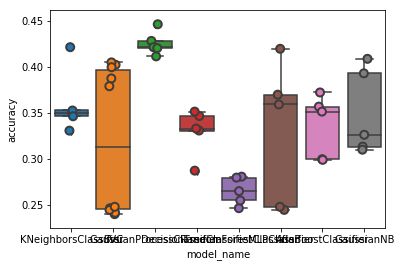

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)

sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [270]:
cv_df.groupby('model_name').accuracy.mean()

model_name
AdaBoostClassifier           0.336147
DecisionTreeClassifier       0.330149
GaussianNB                   0.350605
GaussianProcessClassifier    0.425892
KNeighborsClassifier         0.360612
MLPClassifier                0.328556
RandomForestClassifier       0.265656
SVC                          0.319682
Name: accuracy, dtype: float64

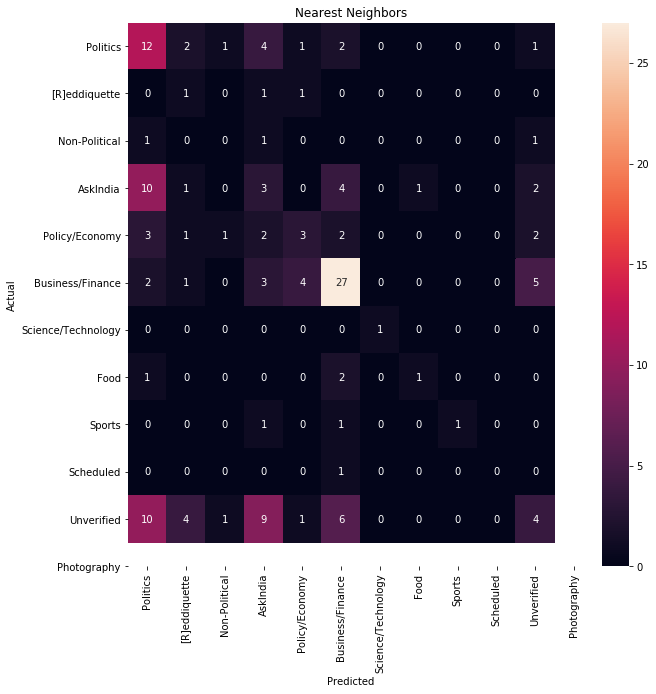

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.31      0.52      0.39        23
     [R]eddiquette       0.10      0.33      0.15         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.12      0.14      0.13        21
    Policy/Economy       0.30      0.21      0.25        14
  Business/Finance       0.60      0.64      0.62        42
Science/Technology       1.00      1.00      1.00         1
              Food       0.50      0.25      0.33         4
            Sports       1.00      0.33      0.50         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.27      0.11      0.16        35

       avg / total       0.36      0.35      0.34       150



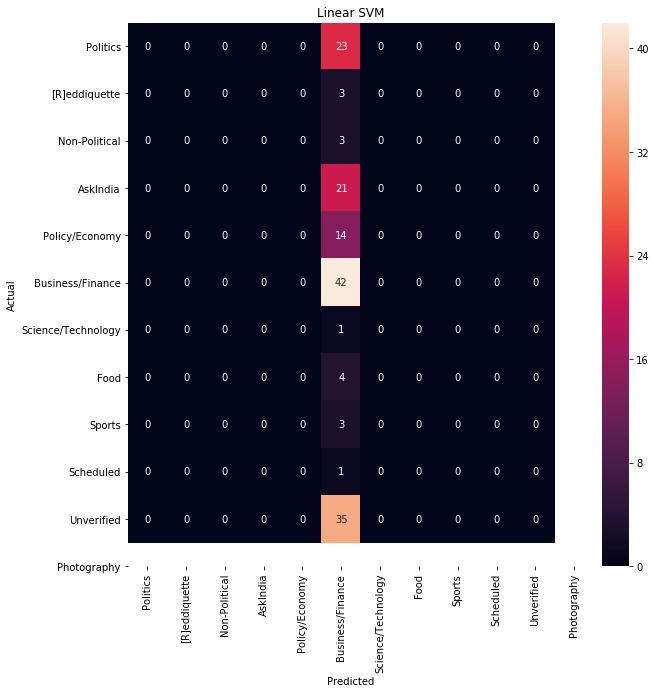

                    precision    recall  f1-score   support

          Politics       0.00      0.00      0.00        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.28      1.00      0.44        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.00      0.00      0.00        35

       avg / total       0.08      0.28      0.12       150



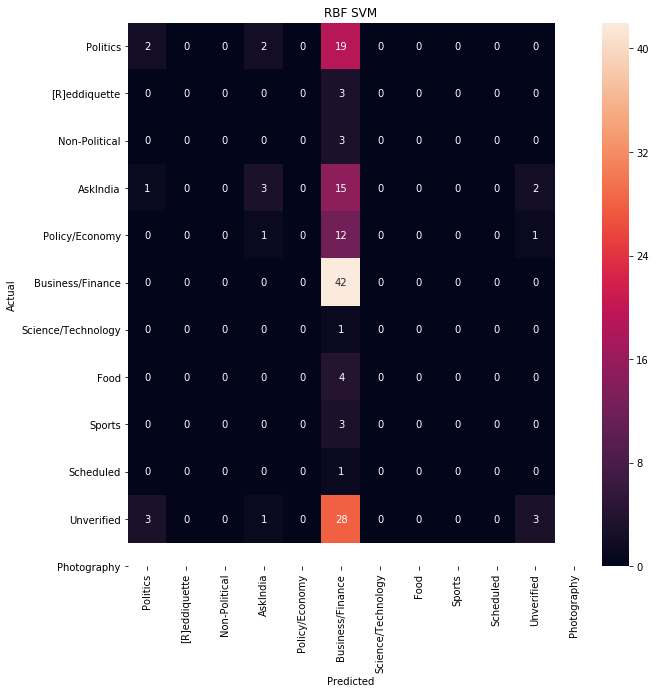

                    precision    recall  f1-score   support

          Politics       0.33      0.09      0.14        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.43      0.14      0.21        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.32      1.00      0.49        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.50      0.09      0.15        35

       avg / total       0.32      0.33      0.22       150



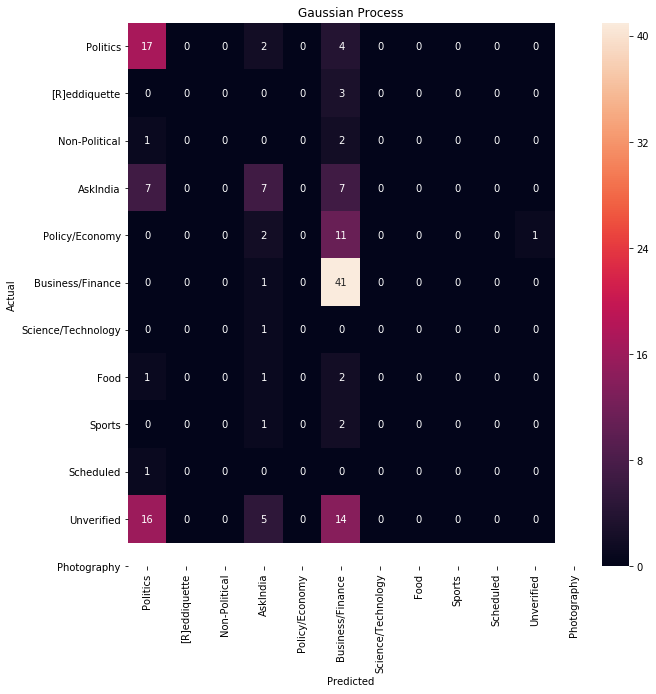

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.40      0.74      0.52        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.35      0.33      0.34        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.48      0.98      0.64        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.00      0.00      0.00        35

       avg / total       0.24      0.43      0.31       150



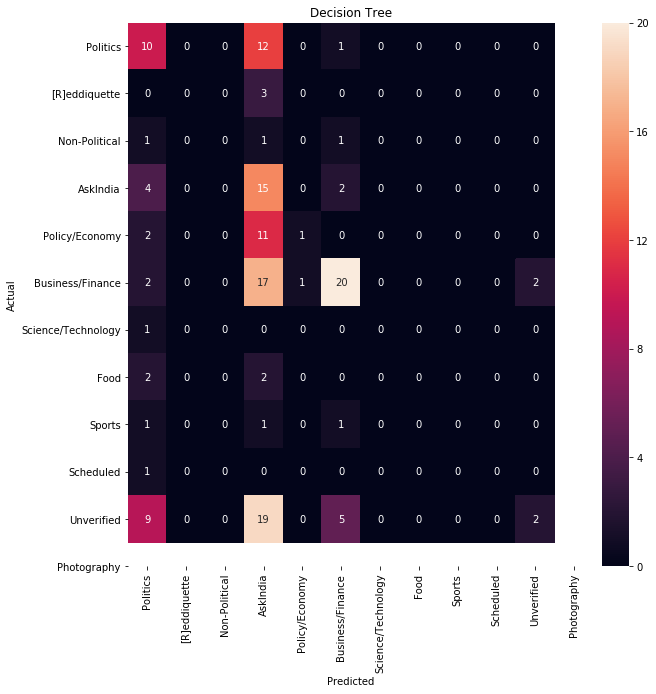

                    precision    recall  f1-score   support

          Politics       0.30      0.43      0.36        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.19      0.71      0.29        21
    Policy/Economy       0.50      0.07      0.12        14
  Business/Finance       0.67      0.48      0.56        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.50      0.06      0.10        35

       avg / total       0.42      0.32      0.29       150



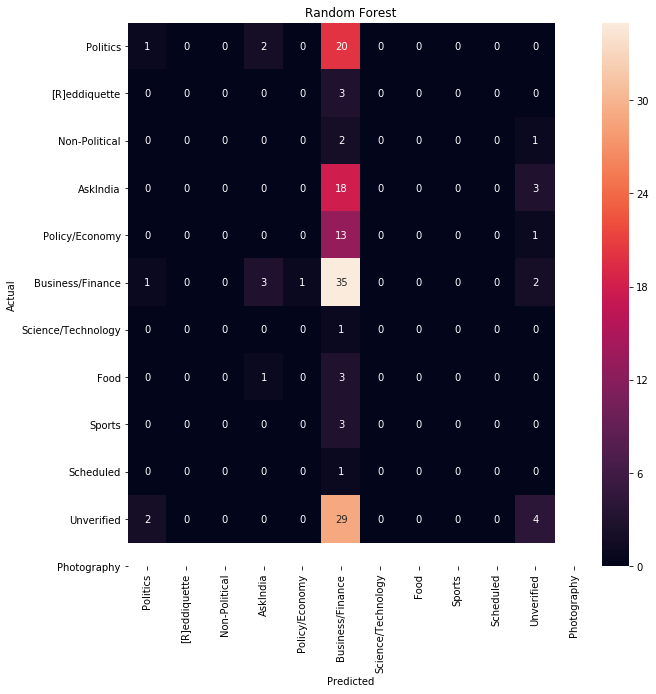

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.25      0.04      0.07        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.27      0.83      0.41        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.36      0.11      0.17        35

       avg / total       0.20      0.27      0.17       150



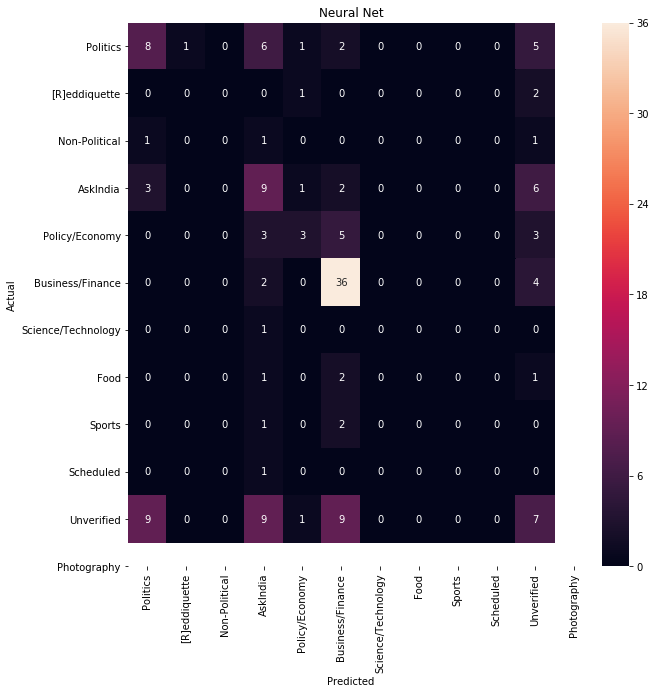

                    precision    recall  f1-score   support

          Politics       0.38      0.35      0.36        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.26      0.43      0.33        21
    Policy/Economy       0.43      0.21      0.29        14
  Business/Finance       0.62      0.86      0.72        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.24      0.20      0.22        35

       avg / total       0.37      0.42      0.38       150



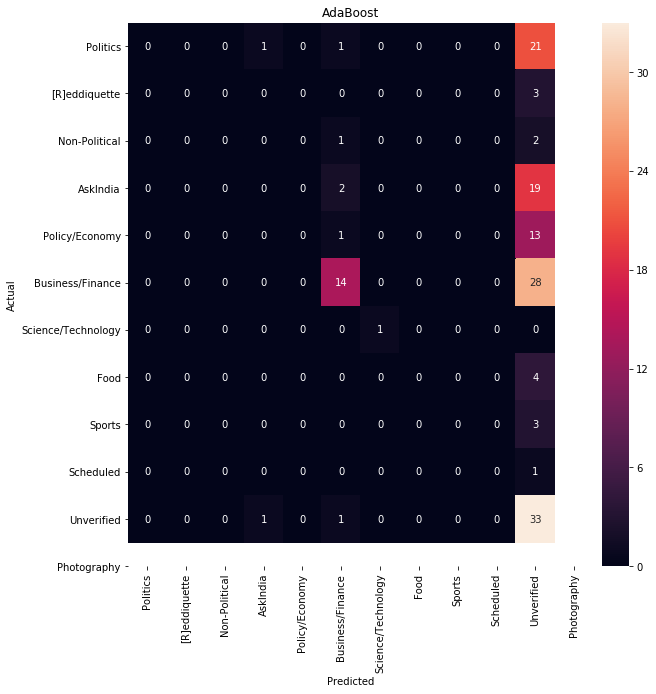

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.00      0.00      0.00        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.70      0.33      0.45        42
Science/Technology       1.00      1.00      1.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.26      0.94      0.41        35

       avg / total       0.26      0.32      0.23       150



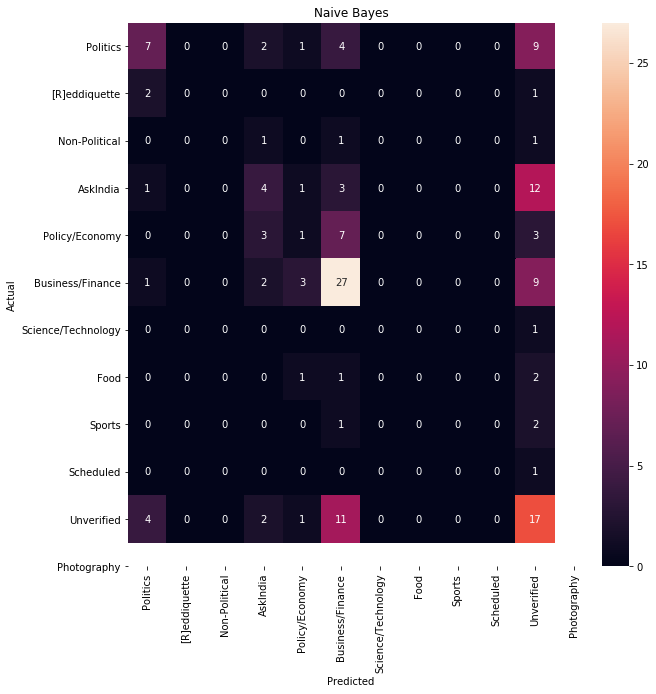

                    precision    recall  f1-score   support

          Politics       0.47      0.30      0.37        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.29      0.19      0.23        21
    Policy/Economy       0.12      0.07      0.09        14
  Business/Finance       0.49      0.64      0.56        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.29      0.49      0.37        35

       avg / total       0.33      0.37      0.34       150



In [292]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#     LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0),
# ]

# names = [
#     "RandomForest",
#     "LinearSVC",
#     "Multinomial Naive Bayes",
#     "Logistic Regression"
# ]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

models = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]

for (model, name) in zip(models, names):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=data.flair.unique(), yticklabels=data.flair.unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=data.flair.unique()))


# Word2Vec

In [15]:
feature_df

,feature,flair
0,Kashmir News Coverage - 3/r/india/comments/cyj...,6
1,Happy Teachers Day/r/india/comments/czue7z/hap...,11
2,"I work in medical store, today 10 year old gir...",11
3,I transcribed the full text of Dr. Manmohan Si...,6
4,Shashi Tharoor: I am a proud Hindu because my ...,6
...,...,...
744,Was the exclusion of four banks a political ga...,5
745,"After Sikh girl's forced conversion in Lahore,...",6
746,Nalanda: Hindu residents of Mari village take ...,11
747,Help me find the news article please/r/india/c...,6


In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
feature_df['feature'] = feature_df['feature'].apply(lambda x: [token.text for token in nlp(x)])
feature_df

,feature,flair
0,"[Kashmir, News, Coverage, -, 3/r, /, india, /,...",6
1,"[Happy, Teachers, Day, /, r, /, india, /, comm...",11
2,"[I, work, in, medical, store, ,, today, 10, ye...",11
3,"[I, transcribed, the, full, text, of, Dr., Man...",6
4,"[Shashi, Tharoor, :, I, am, a, proud, Hindu, b...",6
...,...,...
744,"[Was, the, exclusion, of, four, banks, a, poli...",5
745,"[After, Sikh, girl, 's, forced, conversion, in...",6
746,"[Nalanda, :, Hindu, residents, of, Mari, villa...",11
747,"[Help, me, find, the, news, article, please, /...",6


In [94]:
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [114]:
GLOVE_6B_50D_PATH = "glove.6B.300d.txt"
GLOVE_840B_300D_PATH = "glove.840B.300d.txt"
encoding="utf-8"

import struct 

glove_small = {}
all_words = set(w for words in feature_df["feature"] for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [119]:
model = Word2Vec(feature_df["feature"], size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

2019-09-10 01:15:11,140 INFO: collecting all words and their counts
2019-09-10 01:15:11,142 INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-10 01:15:11,269 INFO: collected 45146 word types from a corpus of 678367 raw words and 749 sentences
2019-09-10 01:15:11,269 INFO: Loading a fresh vocabulary
2019-09-10 01:15:11,311 INFO: effective_min_count=5 retains 8641 unique words (19% of original 45146, drops 36505)
2019-09-10 01:15:11,312 INFO: effective_min_count=5 leaves 626395 word corpus (92% of original 678367, drops 51972)
2019-09-10 01:15:11,346 INFO: deleting the raw counts dictionary of 45146 items
2019-09-10 01:15:11,348 INFO: sample=0.001 downsamples 53 most-common words
2019-09-10 01:15:11,350 INFO: downsampling leaves estimated 467541 word corpus (74.6% of prior 626395)
2019-09-10 01:15:11,383 INFO: estimated required memory for 8641 words and 100 dimensions: 11233300 bytes
2019-09-10 01:15:11,384 INFO: resetting layer weights
2019-09-10 01:15:13,

In [120]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [121]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim = len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [122]:
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
paramtest7 = { 
    'nestimators':[20]
}

xgb_w2v_tfidf = Pipeline([
    ("w2v vectorizer", TfidfEmbeddingVectorizer(w2v)), 
    ("xgboost", XGBClassifier(
                                learningrate =0.1, 
                                nestimators=250,
                                maxdepth=9, 
                                minchildweight=1, 
                                gamma=0.1, 
                                subsample=0.85, 
                                colsamplebytree=0.75,
                                objective='multi:softprob',
                                nthread=4,
                                scaleposweight=1,
                                seed=27,
                                regalpha=0.01
                        ))
     ]
    )

svc_w2v_tfidf = Pipeline([("tfidf_vectorizer", TfidfEmbeddingVectorizer(w2v)), ("linear svc", SVC(kernel="linear"))])
forest_w2v_tfidf = Pipeline([("tfidf_vectorizer", TfidfEmbeddingVectorizer(w2v)), ("randforest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))])
tree_w2v_tfidf = Pipeline([("tfidf_vectorizer", TfidfEmbeddingVectorizer(w2v)), ("dectree", DecisionTreeClassifier(max_depth=5))])

In [123]:
w2v["."]

array([ 0.48136383,  0.8299584 , -0.289823  ,  0.2862657 ,  1.4023845 ,
       -0.14946191, -0.5783318 ,  1.250455  , -0.83620673, -2.6437802 ,
       -0.26818937, -0.5830293 , -0.03487662,  0.50993216, -0.678142  ,
       -0.79047775, -0.09739365,  0.14772852, -0.52321327,  1.0857002 ,
        1.4913175 , -0.98222804,  1.3954277 , -0.6372911 , -0.84625316,
        0.20822984,  0.12404533,  1.0536647 , -0.13088834,  0.32335597,
        0.32292017,  1.3754733 ,  0.37374038,  0.22213277, -0.66514444,
       -0.28093332, -0.13241093,  0.82296735, -0.15029445,  0.3824074 ,
        0.18228467,  0.6675332 ,  1.3016222 , -0.88549197, -0.44384027,
       -0.2798039 , -1.1385883 ,  0.86474264,  0.87453187,  0.74300814,
        0.16430761, -0.2193414 ,  0.65931326,  0.27254182,  1.1815426 ,
        2.1424193 , -0.31410387,  0.45509586,  0.31266075,  0.4759861 ,
       -0.67011064,  0.5291909 , -0.6229178 , -0.29191405,  1.5520995 ,
        1.710802  , -0.84236085,  0.80177474,  0.6690835 ,  0.50

In [124]:
all_models = [
#     ("mult_nb", mult_nb),
#     ("mult_nb_tfidf", mult_nb_tfidf),
#     ("bern_nb", bern_nb),
#     ("bern_nb_tfidf", bern_nb_tfidf),
#     ("svc", svc),
#     ("svc_tfidf", svc_tfidf),
#     ("w2v", etree_w2v),
#     ("w2v_tfidf", etree_w2v_tfidf),
#     ("xgb_w2v_tfidf", xgb_w2v_tfidf),
    ("svc_w2v_tfidf", svc_w2v_tfidf),
    ("forest_w2v_tfidf", forest_w2v_tfidf),
    ("tree_w2v_tfidf", tree_w2v_tfidf),
]


unsorted_scores = [(name, cross_val_score(model, feature_df["feature"], feature_df["flair"], cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

d:\codes\precog-task\env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
d:\codes\precog-task\env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [125]:
for score in scores:
    print(score[0], score[1])

forest_w2v_tfidf 0.35197726823226677
tree_w2v_tfidf 0.29500278941252567


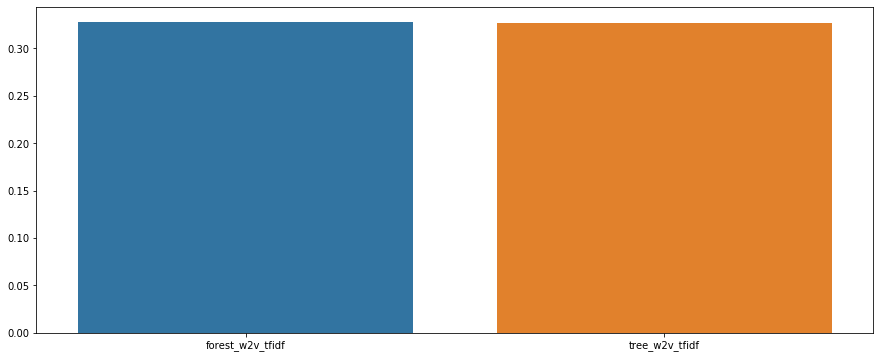

In [93]:
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

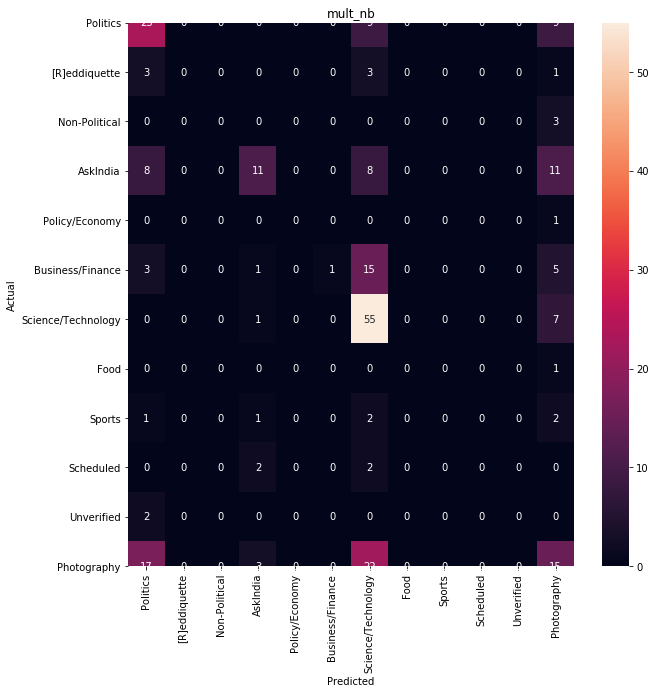

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.40      0.56      0.47        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.58      0.29      0.39        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       1.00      0.04      0.08        25
Science/Technology       0.47      0.87      0.61        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.27      0.26      0.27        57

          accuracy                           0.42       248
         macro avg       0.23      0.17      0.15       248
      weighted avg       0.44      0.42      0.36       248



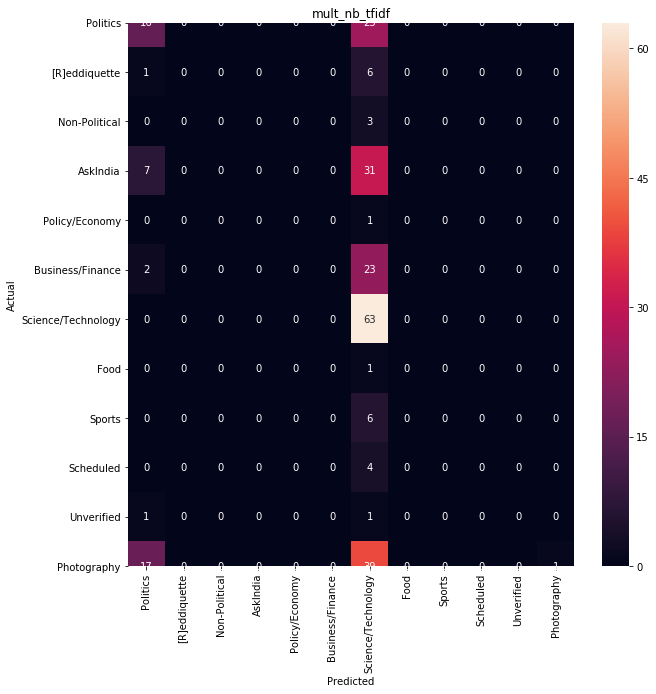

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.36      0.39      0.38        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.00      0.00      0.00        25
Science/Technology       0.31      1.00      0.47        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       1.00      0.02      0.03        57

          accuracy                           0.32       248
         macro avg       0.14      0.12      0.07       248
      weighted avg       0.37      0.32      0.19       248



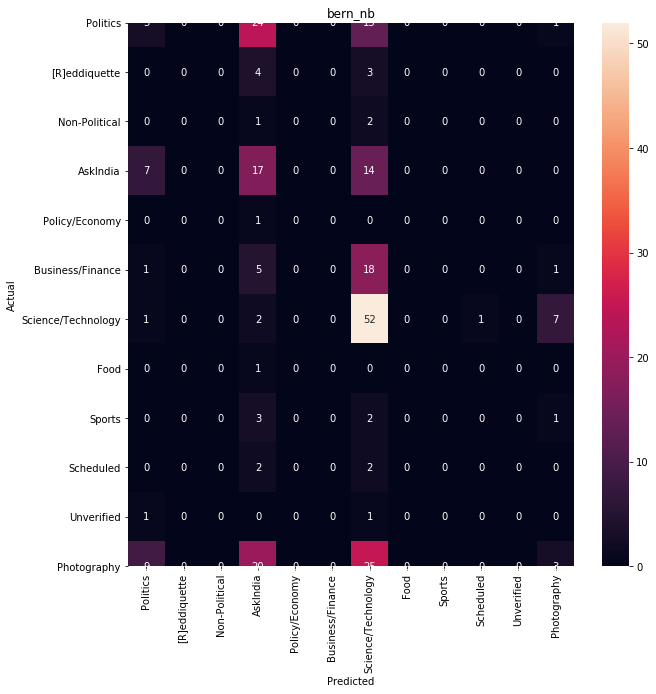

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.14      0.07      0.10        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.21      0.45      0.29        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.00      0.00      0.00        25
Science/Technology       0.39      0.83      0.53        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.23      0.05      0.09        57

          accuracy                           0.30       248
         macro avg       0.08      0.12      0.08       248
      weighted avg       0.21      0.30      0.22       248



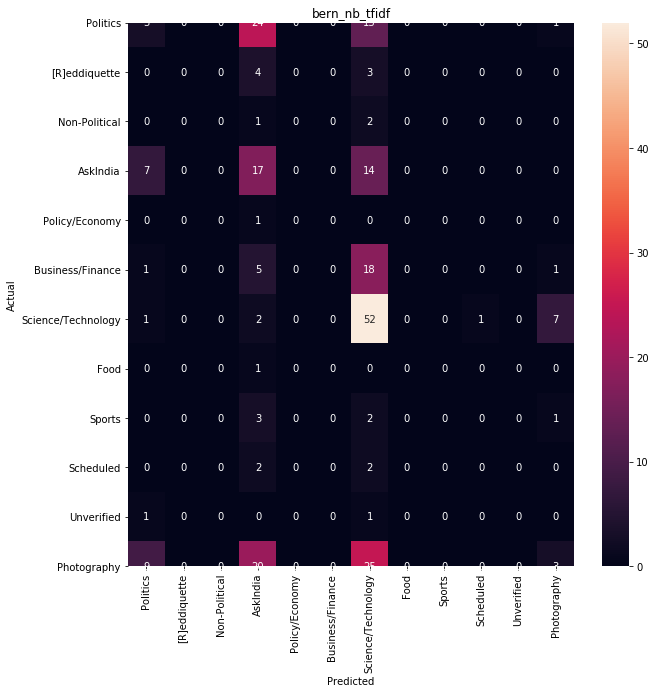

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.14      0.07      0.10        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.21      0.45      0.29        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.00      0.00      0.00        25
Science/Technology       0.39      0.83      0.53        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.23      0.05      0.09        57

          accuracy                           0.30       248
         macro avg       0.08      0.12      0.08       248
      weighted avg       0.21      0.30      0.22       248



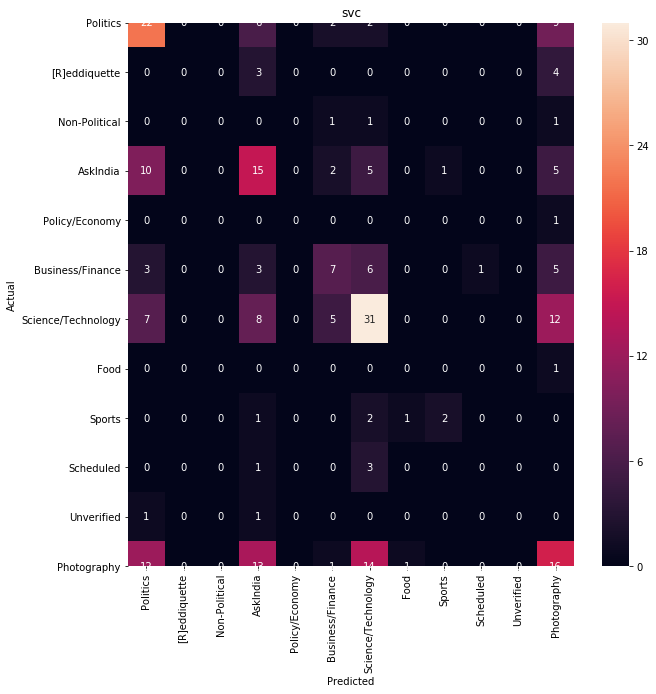

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.40      0.54      0.46        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.29      0.39      0.34        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.39      0.28      0.33        25
Science/Technology       0.48      0.49      0.49        63
              Food       0.00      0.00      0.00         1
            Sports       0.67      0.33      0.44         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.30      0.28      0.29        57

          accuracy                           0.38       248
         macro avg       0.21      0.19      0.20       248
      weighted avg       0.36      0.38      0.36       248



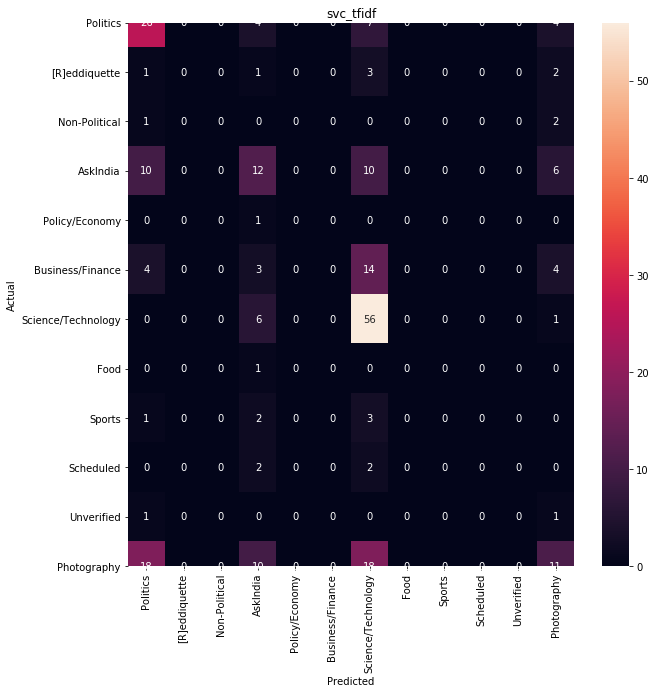

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.42      0.63      0.50        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.29      0.32      0.30        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.00      0.00      0.00        25
Science/Technology       0.50      0.89      0.64        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.35      0.19      0.25        57

          accuracy                           0.42       248
         macro avg       0.13      0.17      0.14       248
      weighted avg       0.32      0.42      0.35       248



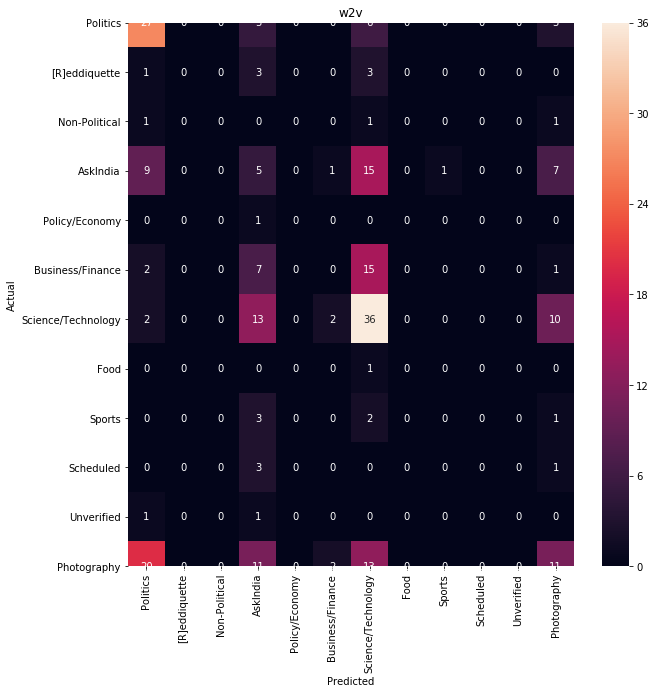

d:\codes\precog-task\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.43      0.66      0.52        41
     [R]eddiquette       0.00      0.00      0.00         7
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.10      0.13      0.11        38
    Policy/Economy       0.00      0.00      0.00         1
  Business/Finance       0.00      0.00      0.00        25
Science/Technology       0.39      0.57      0.46        63
              Food       0.00      0.00      0.00         1
            Sports       0.00      0.00      0.00         6
         Scheduled       0.00      0.00      0.00         4
        Unverified       0.00      0.00      0.00         2
       Photography       0.31      0.19      0.24        57

          accuracy                           0.32       248
         macro avg       0.10      0.13      0.11       248
      weighted avg       0.26      0.32      0.28       248



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
    ("xgb_w2v_tfidf", xgb_w2v_tfidf),
    ("svc_w2v_tfidf", svc_w2v_tfidf),
    ("forest_w2v_tfidf", forest_w2v_tfidf),
    ("tree_w2v_tfidf", tree_w2v_tfidf),
]
for item in all_models:
    name, model = item[0], item[1]
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(feature_df["feature"], feature_df["flair"], data.index, test_size=0.33, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=classes))

ImportError: cannot import name 'grid_search' from 'sklearn' (d:\codes\precog-task\env\lib\site-packages\sklearn\__init__.py)